# Определение стоимости автомобилей

<br>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
<br>Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

<br>**Инструкция по выполнению проекта:**
<br>Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
<br>Загрузите и подготовьте данные.
<br>Обучите разные модели. Для каждой попробуйте различные гипепараметеры.
<br>Проанализируйте скорость работы и качество моделей.
<br>**Примечания:**
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.


<br><br>**Признаки**
<br>*DateCrawled* — дата скачивания анкеты из базы
<br>*VehicleType* — тип автомобильного кузова
<br>*RegistrationYear* — год регистрации автомобиля
<br>*Gearbox* — тип коробки передач
<br>*Power* — мощность (л. с.)
<br>*Model* — модель автомобиля
<br>*Kilometer* — пробег (км)
<br>*RegistrationMonth* — месяц регистрации автомобиля
<br>*FuelType* — тип топлива
<br>*Brand* — марка автомобиля
<br>*NotRepaired* — была машина в ремонте или нет
<br>*DateCreated* — дата создания анкеты
<br>*NumberOfPictures* — количество фотографий автомобиля
<br>*PostalCode* — почтовый индекс владельца анкеты (пользователя)
<br>*LastSeen* — дата последней активности пользователя

<br>**Целевой признак -** Price — цена (евро)

In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb


from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression,Ridge,RidgeCV,LassoCV,Ridge,Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,  OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso, Ridge, RidgeCV,LassoCV
from catboost import CatBoostRegressor, Pool
import lightgbm as LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')



RNS = 12345

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Хорошая структуризация импортов

## Подготовка данных

Загрузим файл под переменной *data*. Выведем первые пять строк датафрейма:

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#приведем заголовки столбцов к нижнему регистру
data.columns = [x.lower() for x in data.columns]

Выведем информацию о данных:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

С помощью функции выведем информацию об уникальных значениях в столбцах:


In [5]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
show_rows(data)

Уникальные значения столбца datecrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца vehicletype
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца registrationyear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

С помощью функции выведем столбцы с наличием пропусков, укажем их количество и процент:

### Обработка пропусков

In [6]:
def proc_isna(data_frame):
    for column in data_frame.columns:
        if data_frame[column].isna().sum() != 0:
            print('_________________________________')
            print('Столбец: ', column)
            print('Количество пропусков: ', data_frame[column].isna().sum())
            print('Процент пропусков: ', round(((data_frame[column].isna().sum()*100)/len(data_frame)), 2))
            
proc_isna(data)

_________________________________
Столбец:  vehicletype
Количество пропусков:  37490
Процент пропусков:  10.58
_________________________________
Столбец:  gearbox
Количество пропусков:  19833
Процент пропусков:  5.6
_________________________________
Столбец:  model
Количество пропусков:  19705
Процент пропусков:  5.56
_________________________________
Столбец:  fueltype
Количество пропусков:  32895
Процент пропусков:  9.28
_________________________________
Столбец:  notrepaired
Количество пропусков:  71154
Процент пропусков:  20.08


Пропуски имеются в столбцах с данными:
- VehicleType — тип автомобильного кузова
- Gearbox — тип коробки передач
- Model — модель автомобиля
- FuelType — тип топлива
- NotRepaired — была машина в ремонте или нет

Как видно из полученных данных, количество пропусков в столбцах составляет от 5,56% до 20.08%. И если 5% можно принебречь и удалить строки с ними, то 10-20% уже значительное количество и удаление такого объема данных приведет к искажению результатов. Какого-либо способа заполнить пропуски на основании других параметров в строке нет. Так как значения в столбце представляют собой  категориальные признаки, то логичным выходом в такой ситуации видется заполнение пропусков: 
- наиболее часто встречающимся значением - в столбце *Gearbox*(т к иных вариантов кроме ручной и автоматической коробки передач логически не дано), *VehicleType, Model*(среди уникальных сначений есть other и при необычных типе кузова или модели выставили бы его, а при обычном - могли и забыть), *FuelType* по тем же причинам. 
- в столбце NotRepaired логичней заполнить пропуски отрицательным значением.
<br>Выполняем заполнение с помощью функций *fillna()* и *mode()*:


In [7]:
data["vehicletype"] = data["vehicletype"].fillna(data["vehicletype"].mode().values[0])
data["gearbox"] = data["gearbox"].fillna(data["gearbox"].mode().values[0])
data["model"] = data["model"].fillna(data["model"].mode().values[0])
data["fueltype"] = data["fueltype"].fillna(data["fueltype"].mode().values[0])
data["notrepaired"] = data["notrepaired"].fillna("no")
#data.isna().sum()

### Обработка дубликатов

Проверяем наличие дублирующих друг друга значений в столбцах с категориальными признаками:

In [8]:
categorial_columns = ["vehicletype","gearbox","model","fueltype","brand","notrepaired"]
for column in categorial_columns:
    print(column, pd.Series(data[column].unique()).str.lower().duplicated().sum())

vehicletype 0
gearbox 0
model 0
fueltype 0
brand 0
notrepaired 0


Проверяем наличие полностью дублирующих друг друга строк:


In [9]:
data.duplicated().sum()

5

Количество незначительное. Избавляемся от дубликатов:

In [10]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Столбцы с datetime

Рассмотрим столбцы, содержащие даты.
Приведем данные к типу datetime и отсортируем по столбцу с датой скачивания анкеты:

In [11]:
data[["datecrawled", "datecreated", "lastseen"]] = data[["datecrawled", "datecreated", "lastseen"]].apply(pd.to_datetime)
data['datecrawled'].sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
176823   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
324763   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: datecrawled, Length: 354364, dtype: datetime64[ns]

Можно сделать вывод, что анкеты скачивали примерно в течение месяца, т е нет аномальных значений, большого разброса во времени и существенных различиях во временных точках, когда данные анкет решили посчитать актуальными.

Отсортируем по столбцу с датой создания анкеты:

In [12]:
data['datecreated'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
251300   2016-04-07
324657   2016-04-07
227785   2016-04-07
37053    2016-04-07
199405   2016-04-07
Name: datecreated, Length: 354364, dtype: datetime64[ns]

За временнные рамки по данному параметру можно считать с 2014 по 2016 года. Однако видно, что за 2014 год в выборке имеется только одна анкета. Чтобы узнать количество анкет за 2015 год выведем данные методом *value_counts()*:

In [13]:
pd.DatetimeIndex(data['datecreated']).year.value_counts()

2016    354338
2015        25
2014         1
Name: datecreated, dtype: int64

In [14]:
print('Процент анкет за 2014-2015гг:', round(26*100/len(data), 3))


Процент анкет за 2014-2015гг: 0.007


Выходит, что в 2015 году было создано 25 анкет, из которых >23 - во второй половине года, а в 2016 самая последняя анкета из выборки создана в апреле. Можно предположить, что   в 2014-2015 году сервис не функционировал и анкеты тестовые, либо это недочет собиравших выборку. Т к количество "сомнительных" анкет невелико, есть резон их удалить.

In [15]:
data = data.drop(data.query('datecreated<2016').index)
pd.DatetimeIndex(data['datecreated']).year.value_counts()

2016    354338
Name: datecreated, dtype: int64

### Заключение

***Первичная обработка данных завершена.***

Теперь можно исключить столбцы с данными, которые в дальнейшем не потребуются.
- datecrawled - дата скачивания не важна, тк в один промежуток времени формировалась база;
- datecreated - при других данных можно было бы учитывать, но тут достаточно однородная выборка, чтобы пренебречь(т к большую роль сыграл бы год, а не месяц);
- lastseen - в данной работе не важна;
- numberofpictures -  столбец заполнен нулевыми значениями, можно зделать вывод, что фото ресурсом не предусмотрены;
- postalcode - месторасположение можно было бы проанализировать при наличии дополнительных данных.


Создаем переменную с копией исходного документа и выполняем удаление:

In [17]:
df = data.copy()
df= df.drop(["datecrawled","datecreated","lastseen","numberofpictures","postalcode"], axis = 1)
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354338 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354338 non-null  int64 
 1   vehicletype        354338 non-null  object
 2   registrationyear   354338 non-null  int64 
 3   gearbox            354338 non-null  object
 4   power              354338 non-null  int64 
 5   model              354338 non-null  object
 6   kilometer          354338 non-null  int64 
 7   registrationmonth  354338 non-null  int64 
 8   fueltype           354338 non-null  object
 9   brand              354338 non-null  object
 10  notrepaired        354338 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


Выведем статистические данные по таблице:

In [19]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,354338.00000,354338.000000,354338.000000,354338.000000,354338.000000
mean,4416.44183,2004.234519,110.093510,128212.963329,5.714736
std,4514.05169,90.231883,189.857678,37903.819286,3.726451
min,0.00000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.00000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.00000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.00000,2008.000000,143.000000,150000.000000,9.000000
max,20000.00000,9999.000000,20000.000000,150000.000000,12.000000


**Исходя из полученных данных:**

<!div class="mx-tdBreakAll">
|Столбец| ||
|:----------|:-----------|:------------|
|**registrationyear**|Присутствуют аномальные значения года регистрации автомобиля  |Логично установить некие максимально и минимально возможные границы и заменить аномальные значения датами границ|
|**registrationmonth**| втсречается значение 0, что не может соответствовать действительности  |заменяем нулевые значения на 1| 
|**power**| присутствуют аномально высокие и низкие значения|найдем выбросы и выполним замену|
|**kilometer**|ничего подозрительного   | | 
|**price**|имеются нулевые значения, а так же высокое стандартное отклонение|выполним поиск выбросов|
 </div>

## Работа с выбросами

In [20]:
#функция для вычисления процентов:
def part_of_value(df1,df):
    return df1.shape[0]/df.shape[0]*100

### ***registrationyear***

Выведем сортированный список уникальных значеий года регистрации:

In [21]:
sorted(df.registrationyear.unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Визуализируем распределение регистраций авто по годам:

Text(0, 0.5, 'Количество')

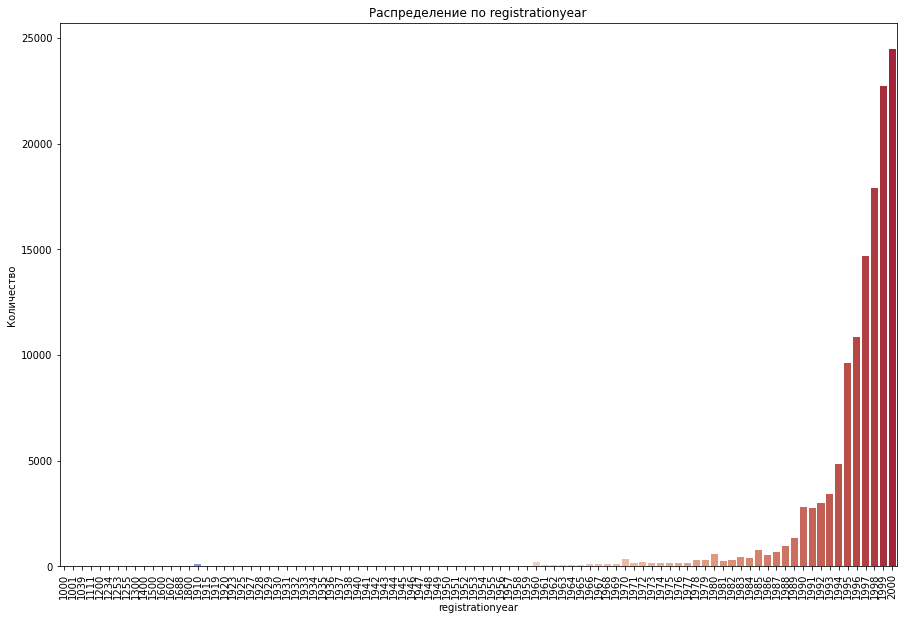

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=90)
sns.countplot(x='registrationyear', data=df[df['registrationyear']<=2000], palette='coolwarm')
ax.set_title('Распределение по ' + 'registrationyear')
plt.ylabel('Количество')

Text(0, 0.5, 'Количество')

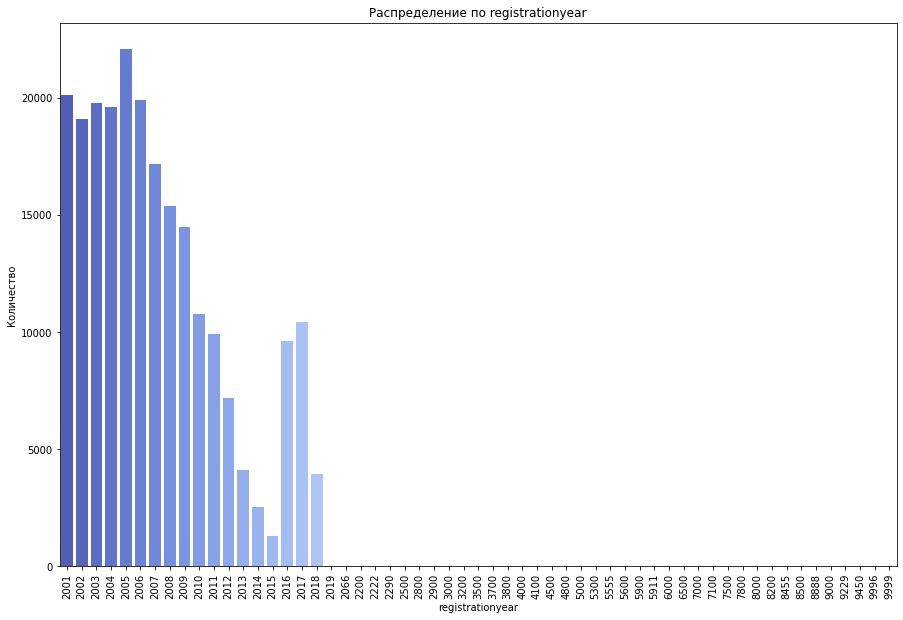

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=90)
sns.countplot(x='registrationyear', data=df[df['registrationyear']>2000], palette='coolwarm')
ax.set_title('Распределение по ' + 'registrationyear')
plt.ylabel('Количество')

По гистограммам видно, что значения выбросов до 2000г незначительны. Но после 2016, года выгрузки анкет, имеется значительное количество регистраций автомобилей в 2017-2018 годах, затем - так же незначительное количество.

На основании полученных данных можно определить границы максимально и минимально возможных дат регистрации как: 
- верхняя граница: т к больше информации о содержании и происхождении данных нет, можно, основываясь на наличии достаточно дорогостоящих автомобилей, предположить их высокую антикварную ценность, т е установить 1910 год как верхнюю границу(первое авто - 1886г). однако при большом количестве аномалий раньше этой даты, есть риск искажения общей картины. Поэтому логичной вижу замену на наиболее часто встречающуюся дату;
- нижняя граница - т к данные выгружали в марте-апреле 2016 года, можно предположить, что минимально возможный год регистрации автомобиля - 2016, но если число регистраций за 2017-2018 год подвести под 2016, мы получим значительный перекос количества по годам. Теоретически - наличие 17-18гг можно объяснить покупкой авто и запланированной его регистрацией или предзаказом новой модели. Решено установить нижнюю границу как 2018 год.

In [24]:
def normalisation_registrationyear(value):
    if value > 2018:
        return 2018
    elif value < 1910:
        return 1910 #df['registrationyear'].mode().values[0]
    else:
        return value
df["registrationyear"] = df["registrationyear"].apply(normalisation_registrationyear)

#sorted(df.registrationyear.unique())

Text(0, 0.5, 'Количество')

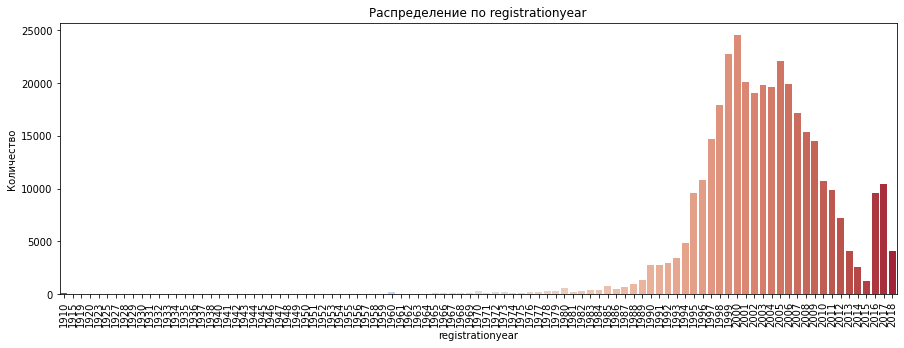

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.xticks(rotation=90)
sns.countplot(x='registrationyear', data=df, palette='coolwarm')
ax.set_title('Распределение по ' + 'registrationyear')
plt.ylabel('Количество')

### ***registrationmonth***

Text(0, 0.5, 'Количество')

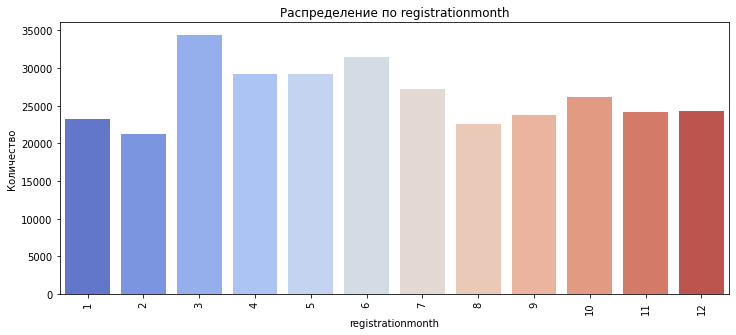

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=90)
sns.countplot(x='registrationmonth', data=df[df['registrationmonth']>0], palette='coolwarm')
ax.set_title('Распределение по ' + 'registrationmonth')
plt.ylabel('Количество')

In [27]:
df.registrationmonth.value_counts(normalize=True, sort = False) * 100

0     10.540783
1      6.551090
2      6.001614
3      9.699778
4      8.259346
5      8.226891
6      8.890664
7      7.679391
8      6.385711
9      6.719291
10     7.365566
11     6.825122
12     6.854754
Name: registrationmonth, dtype: float64

In [28]:
month_arr = sorted(df.registrationmonth.unique())
month_arr

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [29]:
numm= -1
for index in month_arr:
    numm += 1
    
    print(numm, ' = ', round(part_of_value(df1 = df[df['registrationmonth']== index], df=df), 2))

0  =  10.54
1  =  6.55
2  =  6.0
3  =  9.7
4  =  8.26
5  =  8.23
6  =  8.89
7  =  7.68
8  =  6.39
9  =  6.72
10  =  7.37
11  =  6.83
12  =  6.85


Вычисляем процент каждого значения до замены:

Кроме нулевого значения, всё вписывается в норму, однако под нулевым значением находится значительное количество регистраций. Производим замену и выводим проценты:

In [30]:
df.registrationmonth = df.registrationmonth.replace(0, 1, inplace=False)


In [31]:
numm= -1
for index in month_arr:
    numm += 1
    
    print(numm, ' = ', round(part_of_value(df1 = df[df['registrationmonth']== index], df=df), 2))

0  =  0.0
1  =  17.09
2  =  6.0
3  =  9.7
4  =  8.26
5  =  8.23
6  =  8.89
7  =  7.68
8  =  6.39
9  =  6.72
10  =  7.37
11  =  6.83
12  =  6.85


Визуализируем полученные данные:

Text(0, 0.5, 'Количество')

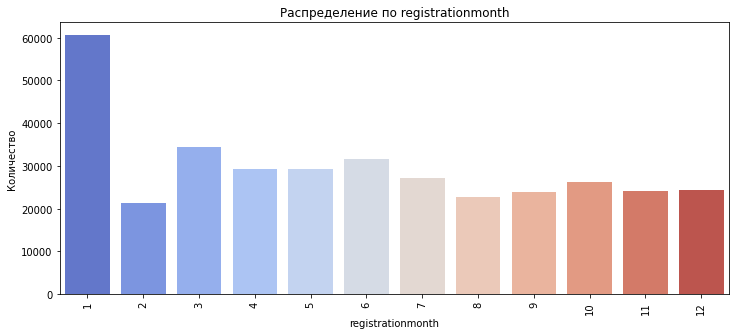

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=90)
sns.countplot(x='registrationmonth', data=df, palette='coolwarm')
ax.set_title('Распределение по ' + 'registrationmonth')
plt.ylabel('Количество')

Получили умеренный перекос к январю, но другие варианты заполнения пропусков не подходят. Будем списывать подъем на новогодние покупки.

### ***power***

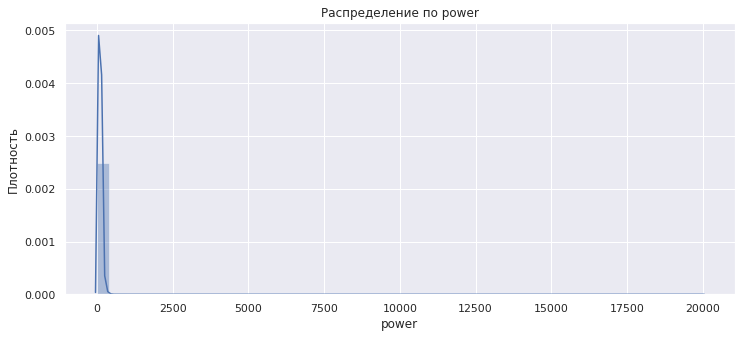

In [33]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['power'])
ax.set_title('Распределение по ' + 'power')
plt.ylabel('Плотность');

Подберем квадрили при которых границы будут укладываться в рамки адекватных значений:

In [34]:
df.power.describe(percentiles=[ .1, .125, .15, .25, .5, .75, .95, .98, .99, .998])

count    354338.000000
mean        110.093510
std         189.857678
min           0.000000
10%           0.000000
12.5%        45.000000
15%          54.000000
25%          69.000000
50%         105.000000
75%         143.000000
95%         218.000000
98%         258.000000
99%         300.000000
99.8%       420.000000
max       20000.000000
Name: power, dtype: float64

In [35]:
unnormal_power=df[(df.power < df.power.quantile(.15)) | (df.power > df.power.quantile(.998))]
print(part_of_value(df1 = unnormal_power, df=df))
unnormal_power125=df[(df.power < df.power.quantile(.125)) | (df.power > df.power.quantile(.998))]
print(part_of_value(df1 = unnormal_power125, df=df))



14.705450727836133
12.322697537379563


Получаем значительные проценты. Однако, нулевые значения могут принадлежать автомобилям с дефектами(сломанными, продающимися на запчасти/металлолом). 

Смотрим на проценты с аномально высокой скоростью:

In [36]:
unnormal_power95=df[df.power > df.power.quantile(.95)]
print(part_of_value(df1 = unnormal_power95, df=df))
unnormal_power98=df[df.power > df.power.quantile(.98)]
print(part_of_value(df1 = unnormal_power98, df=df))
unnormal_power998=df[df.power > df.power.quantile(.998)]
print(part_of_value(df1 = unnormal_power998, df=df))

4.739542470748269
1.9724105232856763
0.19472932623653122


Проценты небольшие, скорость в 420лс реалистичная для агротехники, удаляем то, что выше 99.8 квартиля. 

In [37]:
df.drop(unnormal_power998.index,  inplace=True)

Мощность двигателя ниже 15% и выше 95% квантилей, является аномальным. Удалим их из респределения:

In [38]:
df.power.describe(percentiles=[ .1, .15, .25, .5, .75, .95])

count    353648.000000
mean        106.153198
std          62.524158
min           0.000000
10%           0.000000
15%          54.000000
25%          69.000000
50%         105.000000
75%         141.000000
95%         218.000000
max         420.000000
Name: power, dtype: float64

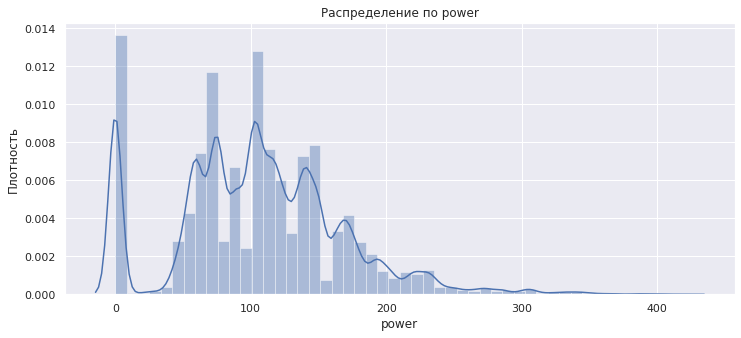

In [39]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['power'])
ax.set_title('Распределение по ' + 'power')
plt.ylabel('Плотность');

***price***

Цена автомобиля является целевым признаком, поэтому чтобы избежать некачественного обучения при дальнейшей работе, нужно хорошо обдумать действия с аномалиями.

In [40]:
df['price'].value_counts().head(10)

0       10735
500      5660
1500     5383
1000     4641
1200     4588
2500     4431
600      3810
3500     3786
800      3779
2000     3427
Name: price, dtype: int64

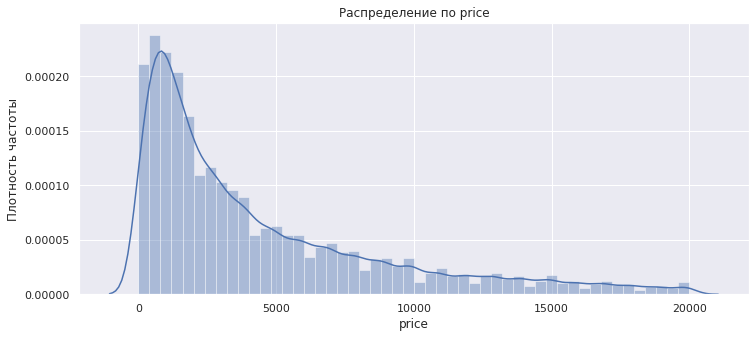

In [41]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['price'])
ax.set_title('Распределение по ' + 'price')
plt.ylabel('Плотность частоты');

In [42]:
df.price.describe(percentiles=[.05, .1, .15, .25, .5, .75, .95])

count    353648.000000
mean       4410.499966
std        4506.134648
min           0.000000
5%          200.000000
10%         499.000000
15%         650.000000
25%        1050.000000
50%        2700.000000
75%        6399.000000
95%       14500.000000
max       20000.000000
Name: price, dtype: float64

In [43]:
print('Процент нулевых значений цены: ', part_of_value(df1 = df[(df['price'] == 0)], df=df))

Процент нулевых значений цены:  3.035504230194996


Цену в 0 евро можно посчитать аномальной, однако есть вероятность, что автомобиль отдают на запчасти/металлолом/просто отдают(туда же идут нереалистично низкие цены). И хотя есть вероятность, что значение пропущено, процент нулевых цен достаточно низок. Можно принять их за действиетльные и оставить, т к цена - целевой признак и удаление присутствующих на рынке значений несет риск неудостоверного результата в дальнейшем.

Так же имеем достаточно высокие цены за авто, однако ограничивать в этом направлении смысла не вижу, тк по столбцу о регистрации автомобиля можно сказать, что есть раритетные автомобили в выборке, прочие дорогостоящие модели тоже не удастся исключить.

14% - это значительная часть выборки, решено оставить нижней границей 10 квартиль.

### Заключение

Выведем размеры исходного датафрейма и его копии после обработки и рассчитаем процент удаленных данных:

In [44]:
print(data.shape, df.shape)
print('Процент удаленных данных:', round(100 - part_of_value(df1 = df, df=data), 2))

(354338, 16) (353648, 11)
Процент удаленных данных: 0.19


***Вывод:*** после обработки выбросов процент удаленных данных достаточно небольшой. 

## Обучение моделей

In [45]:
#копирую на будущее
df_copy=df.copy()

### Корреляция

Методом *corr* формируем матрицу корреляций и визуализируем:

In [46]:
correlation = df.corr()
correlation

,price,registrationyear,power,kilometer,registrationmonth
price,1.000000,0.366120,0.485995,-0.334820,0.098859
registrationyear,0.366120,1.000000,0.115401,-0.163091,0.046575
power,0.485995,0.115401,1.000000,0.087670,0.119412
kilometer,-0.334820,-0.163091,0.087670,1.000000,0.009538
registrationmonth,0.098859,0.046575,0.119412,0.009538,1.000000


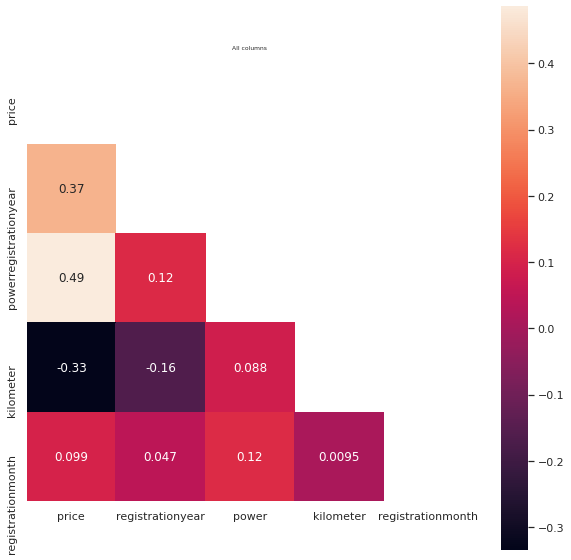

In [47]:
# матрица корреляций между признаками

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(correlation, mask=mask, square=True,annot=True)
    plt.title("All columns", fontsize =6)

Видна высокая корреляция между ценой и мощностью. Но т.к. значения ниже 0,8 то ничего не делаем.

### Кодирование и масштабирование

***Перед началом обучения следует подготовить имеющиеся данные. А именно:***


Столбцы vehicle_type, model, fuel_type, brand, not_repaired. - категориальные признаки. Необходимо их перевести в численные признаки. Используем технику кодирования Ordinal Encoding, так как у нас много значений в категориальных признаков.


Рассортируем столбцы по двум переменным: в *categorical* - названия столбцов с категориальными признаками, в *numeric* - с числовыми.


In [48]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,sedan,1993,manual,0,golf,150000,1,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [75]:
categorical = df.select_dtypes(include='object').columns.to_list()
numeric = ['power', 'kilometer']
# numeric = df.select_dtypes(include='int64').columns.to_list()

print('Столбцы с категориальными данными: ', categorical)
print('Столбцы с числовыми: ', numeric)

Столбцы с категориальными данными:  ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
Столбцы с числовыми:  ['power', 'kilometer']


### Формируем признаки и выборки:

Так как на полноразмерных выборках процессы шли у меня крайне медленно, обучаю модели на "облегченных". Методом *sample()* формирую выборку из 1000 значений.

In [76]:
df_light =  df.sample(10000) 

#до разделения на выборки:
for col in categorical:
    df_light[col] = pd.get_dummies(df_light[col], drop_first=True)


X = df_light.drop('price', axis = 1)
y = df_light['price']
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12345)




In [77]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=123)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, train_size=0.50, test_size=0.50,  random_state=123)


#некодированные  выборки для catboost
x_train_cb= x_train.copy()
x_valid_cb= x_valid.copy()
x_test_cb= x_test.copy()

print('Размеры обучающей выборки:')
print(x_train.shape)
print(y_train.shape)

print('Размеры валидационной выборки:')
print(x_valid.shape)
print(y_valid.shape)

print('Размеры тестовой выборки:')
print(x_test.shape)
print(y_test.shape)

Размеры обучающей выборки:
(6000, 10)
(6000,)
Размеры валидационной выборки:
(2000, 10)
(2000,)
Размеры тестовой выборки:
(2000, 10)
(2000,)


Выполним масштабирование столбцов из *numeric*, исключив целевой признак:

In [78]:
scaler = StandardScaler()
scaler.fit(x_train[numeric])
for col in numeric:
    x_train[col] = scaler.transform(x_train[numeric])
    x_valid[col] = scaler.transform(x_valid[numeric])
    x_test[col] = scaler.transform(x_test[numeric])

In [79]:
x_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
105082,0,2007,1,-0.025421,0,-1.712876,11,0,0,0
299672,1,2007,1,-0.266428,0,-1.716748,3,0,0,0
213019,0,2002,1,-0.362830,0,-1.718297,6,0,0,0
138524,0,2010,1,0.472660,0,-1.704873,3,0,0,0
225765,0,2010,1,0.151317,0,-1.710036,6,0,0,0


Чтобы преобразовать категориальные признаки в численные поможет техника прямого кодирования (One-Hot Encoding, OHE). Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies() чтобы избежать дамми-ловушки, используем аргумент drop_first=True:

Для вычисления RMSE использую формулу:

In [121]:
def RMSE(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = sqrt(mse)
    return rmse


### DummyRegressor

Напишем  DummyRegressor. Используем его как ориентир для оценки качества работы модели для определения  минимальной ожидаемой производительности по конкретной задаче.

In [122]:
y_base = y.copy()
y_base.loc[:] = y.mean()
y_base.head()

base_RMSE = np.sqrt(mean_squared_error(y, y_base))


In [123]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(x_train, y_train)
predictions_dummy_regressor = dummy_regressor.predict(x_test)
rmse_dummy_regressor_model = RMSE(y_test, predictions_dummy_regressor)
print(f'Предсказания "глупой" модели, которая брала просто средние значения правильных ответов: {rmse_dummy_regressor_model:.3f}')

Предсказания "глупой" модели, которая брала просто средние значения правильных ответов: 4501.105


### LinearRegression

Обучим модель линейной регрессии. Оценим время обучения и скорость и качество предсказания (RMSE).


In [124]:
model_lr = LinearRegression()
start = time.time() 
model_lr.fit(x_train, y_train)
linear_regressor_fit_time = time.time() - start

start = time.time() 
predictions_lr = model_lr.predict(x_valid)
linear_regressor_predict_time = time.time() - start
LR_RMSE = RMSE(y_valid, predictions_lr)
print('RMSE линейной регрессиии: ', LR_RMSE)


RMSE линейной регрессиии:  3514.2838144635666


### RandomForestRegressor

Обучим модель случайного леса:

In [125]:
model_forest = RandomForestRegressor(random_state=12345)

max_depth = [10, 15, 20, 25]                   
max_trees = [10, 15, 20, 25] 

forest_params = {'max_depth': max_depth, 'n_estimators': max_trees}
forest_grid_model = GridSearchCV(model_forest, forest_params, cv=3, scoring='neg_mean_squared_error')


In [126]:
%%time
start_time = time.perf_counter()
forest_grid_model.fit(x_train, y_train)
finish_time = time.perf_counter()
forest_grid_fit_time = (finish_time - start_time)


CPU times: user 6.32 s, sys: 23.5 ms, total: 6.35 s
Wall time: 6.36 s


In [127]:
%%time
start_time = time.perf_counter()
predictions_forest_grid_model = forest_grid_model.predict(x_valid)
finish_time = time.perf_counter()
forest_grid_predict_time = (finish_time - start_time)

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 13.3 ms


In [128]:
rmse_grid_forest = RMSE(y_valid, predictions_forest_grid_model)
print(f'Метрика RMSE для случайного леса : {rmse_grid_forest:.3f}')
#поняла, где ошибка

Метрика RMSE для случайного леса : 2271.587


### Обучение моделей градиентного бустинга

#### LightBoost

Обучим модель LightBoost:

In [129]:
lgb_regressor_model = lgb.LGBMRegressor(objective='regression', metric='l2') #, verbose=10)
max_depth = [1, 5] #10, 15, 20, 25]        # из-за скорости выполнения, взяла по минимуму
learning_rate = [0.05, 0.1]   #, 0.15]
num_leaves = [3, 4]
lgb_params = {'max_depth': max_depth, 'learning_rate' : learning_rate, 'num_leaves':num_leaves}
grid_lgb_model = GridSearchCV(lgb_regressor_model, param_grid=lgb_params, scoring='neg_mean_squared_error', cv=3)


In [130]:
%%time
start_time = time.perf_counter()
grid_lgb_model.fit(x_train, y_train)
finish_time = time.perf_counter()
grid_lgb_fit_time = (finish_time - start_time)

CPU times: user 12min 22s, sys: 7.33 s, total: 12min 29s
Wall time: 12min 34s


In [131]:
%%time
start_time = time.perf_counter()
predictions_grid_lgb_model = grid_lgb_model.predict(x_valid)
finish_time = time.perf_counter()
grid_lgb_predict_time = (finish_time - start_time)

CPU times: user 36.9 ms, sys: 141 µs, total: 37.1 ms
Wall time: 82.1 ms


In [132]:
rmse_grid_lgb_model = RMSE(y_valid, predictions_grid_lgb_model)
print(f'Метрика RMSE для модели LGBM : {rmse_grid_lgb_model:.3f}')

Метрика RMSE для модели LGBM : 2292.537


#### Catboost

Обучаем модель Catboost. Эта модель может работать с непреобразованными категориальными признаками, попробуем этот способ. 

Возвращаемся к копии датафрейма *df*.Так же формируем облегченную выборку. Выделяем признаки, масштабируем численные столбцы. Категориальные оставляем без изменений. 



numeric = df_copy.select_dtypes(exclude='object').columns.to_list() 
numeric = numeric[1:]
scaler = StandardScaler()
scaler.fit(df_copy[numeric])

for col in numeric:
    df_copy[col] = scaler.transform(df_copy[numeric])


In [133]:
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

cat_regressor_model = CatBoostRegressor(loss_function='RMSE')

In [134]:
%%time
start_time = time.perf_counter()
cat_regressor_model.fit(x_train_cb, y_train, cat_features = cat_features, verbose = 0)
finish_time = time.perf_counter()
cat_model_fit_time = (finish_time - start_time)



CPU times: user 1.16 s, sys: 88 ms, total: 1.24 s
Wall time: 2.23 s


In [135]:
%%time
start_time = time.perf_counter()
predictions_cat_regressor_model = cat_regressor_model.predict(x_valid_cb)
finish_time = time.perf_counter()
cat_model_predict_time = (finish_time - start_time)



CPU times: user 7.29 ms, sys: 1.08 ms, total: 8.37 ms
Wall time: 7.38 ms


In [136]:
rmse_cat_model = RMSE(y_valid, predictions_cat_regressor_model)
print(f'Метрика RMSE модели Catboost : {rmse_cat_model}')

Метрика RMSE модели Catboost : 2138.8407283331885


## Анализ данных

Сформируем сводную таблицу из полученных данных и выведем на экран:

In [137]:
all_models = {   'model': ['DummyRegressor', 'linear_regression','random_forest', 'LGBM', 'Catboost' ],
                 'значение RMSE': [rmse_dummy_regressor_model, LR_RMSE, rmse_grid_forest, rmse_grid_lgb_model, rmse_cat_model],
                 'время обучения (секунды)': [0, linear_regressor_fit_time, forest_grid_fit_time, grid_lgb_fit_time, cat_model_fit_time],
                 'время предсказания (секунды)': [0, linear_regressor_predict_time,forest_grid_predict_time, grid_lgb_predict_time,cat_model_predict_time]
     }
total_models = pd.DataFrame(all_models, columns=['model', 'значение RMSE', 'время обучения (секунды)', 'время предсказания (секунды)' ])

total_models



,model,значение RMSE,время обучения (секунды),время предсказания (секунды)
0,DummyRegressor,4501.104526,0.000000,0.000000
1,linear_regression,3514.283814,0.005279,0.010575
2,random_forest,2271.587267,6.359681,0.013241
3,LGBM,2292.537194,754.387577,0.082098
4,Catboost,2138.840728,2.225975,0.007353


### Финальное тестирование на выбранной модели

In [138]:
%%time
start_time = time.perf_counter()
predictions_cat_regressor_model = cat_regressor_model.predict(x_test_cb)
finish_time = time.perf_counter()
cat_model_predict_time = (finish_time - start_time)

rmse_cat_model = RMSE(y_test, predictions_cat_regressor_model)
print(f'Метрика RMSE модели Catboost : {rmse_cat_model}')

Метрика RMSE модели Catboost : 2242.3795866681694
CPU times: user 9.99 ms, sys: 0 ns, total: 9.99 ms
Wall time: 9.51 ms


***Выводы:***
- лучшее значение RMSE и скорости  показывает модель CatBoostRegressor. Так же, для работы с ней не требуется преобразование категориальных данных, однако, эта модель показывает более высокий *RMSE*.

Таким образом, согласно целям заказчика, лучшей моделью для использования является *CatBoostRegressor*, т к лучше всего справляется с поставленной задачей.

## Общий вывод

В процессе работы были изучены исходные данные, выполнена их предобработка: 
- привели заголовки столбцов к нижнему регистру;
- заполнены пропуски;
- удалены дубликаты;
- обработаны выбросы;
- логически убрали лишние столбцы;
- выполнили кодирование и масштабирование данных, определили выборки;
- вполнили обучение на базовой модели,моделях линейной регрессии, случайного леса, моделей градиентного бустинга(LightGBM, CatBoost) и свели в таблицу полученные параметры;
- проанализировали скорости обучения и предсказания моделей, их *RMSE*:
   + ***лучшее значение RMSE показывает модель LGBMRegressor, однако у нее достаточно низкая скорость обучения и предсказания.***
   + ***лучшая скорость у CatBoostRegressor и для работы с ней не требуется преобразование категориальных данных, однако, эта модель показывает более высокий RMSE.***


*Таким образом, согласно целям заказчика, лучшей моделью для использования является **LGBMRegressor**, т к лучше всего справляется с поставленной задачей.*